In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scope import ScopeSolver

# Spatial trend filtering
In this example, we show how to deal with the following two spatial trend filtering tasks via ``scope``:
1. block-wise constant trend filtering
2. block-wise linear trend filtering


## Block-wise constant trend filtering

### Introduction
In some applications of spatial data analysis, we are given a set of values $(y_{ij})$ over a grid $1\leq i\leq m, 1\leq j\leq n$, that is, the observed data is a 2-dimensional matrix $Y\in\mathbb{R}^{m\times n}$. The task is to recover the underlying trend of $Y$ which is also referred to as trend filtering or smoothing. For instance, the air polution level $Y$ reported by the air quality monitors over a geographic grid may be perturbated with different noise. While the adjacent locations should have the similar air pollution level. Therefore, we want to approximate the data $Y$ with a block-wise constant matrix $X$ which can better exhibit the trend of true air pollution level.

### Implementation
We illustrate in the following how to deal with this task via ``scope``.

The key observation is that a block-wise constant matrix $X$ can be represented with a sparse matrix $\Theta$.

Specifically, we parameterize $x_{ij}, 1\leq i\leq m, 1\leq j\leq n$ as follows
$$x_{ij}=\sum_{s=1}^i\sum_{t=1}^j\theta_{st},$$
that is, each element in matrix $X$ is the cumsum of the elements of $\Theta$ which lie in the upper left of the corresponding position.

From this parameterization, the element $\theta_{ij}$ actually marks that whether a jump appears in the $(i, j)$ position of $X$ and thus $\Theta$ should be a sparse matrix with few nonzero elements.

The following function ``stf_constant`` implements this algorithm and output a block-wise constant estimation.

In [2]:
def stf_constant(Y, sparsity):
    m, n = Y.shape
    p = m * n

    def custom_objective(params):
        X_hat = jnp.cumsum(jnp.cumsum(params.reshape(m, n), axis=0), axis=1)
        return jnp.mean(jnp.square(Y - X_hat))
    
    solver = ScopeSolver(p, sparsity)
    params = solver.solve(custom_objective)
    X_hat = np.cumsum(np.cumsum(params.reshape(m, n), axis=0), axis=1)
    return X_hat

### Synthetic data example
We generate a synthetic data over a $50\times 50$ grid as follows:
- First, jump matrix $\Theta\in\mathbb{R}^{50\times 50}$ is a sparse with only $3$ nonzero elements;
- Then, the true trend matrix is constructed as the (upper left corner) cumsum  of $\Theta$; 
- Lastly, the data matrix $Y$ is obtained by adding Gaussian noise to $X$.

See the following code for details.

In [3]:
m, n = 50, 50
p = m * n
Theta = np.zeros((m, n))
Theta[0, 0] = 1
Theta[19, 19] = 0.5
Theta[19, 0] = 1
X = np.cumsum(np.cumsum(Theta, axis=0), axis=1)

In the following figure, we visualize the true signal $X$ and nosiy data $Y$ respectively.

The block-wise constant $X$ validates the effectiveness of our parameterization.

The data matrix $Y$ is wiggly and the underlying tren is obscured by the noise.

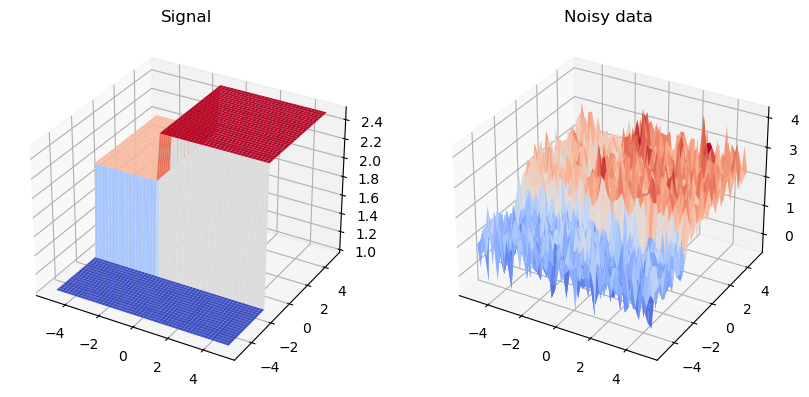

In [4]:
xx1 = np.linspace(-5, 5, m)
xx2 = np.linspace(-5, 5, n)
X1, X2 = np.meshgrid(xx2, xx2)

rng = np.random.default_rng(666)
noise = rng.standard_normal((m, n)) * 0.5
Y = X + noise

fig = plt.figure(figsize=(10, 5))  

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1, X2, X, cmap='coolwarm')
ax1.set_title('Signal')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
ax2.set_title('Noisy data')

plt.show()

We estimate a approximate trend ``X_hat_constant`` with the previously defined function ``stf_constant``.

In [5]:
X_hat_constant = stf_constant(Y, sparsity=3)

The following figure shows that the estimator ``X_hat_constant`` is perfect although the observed data $Y$ is extremely noisy.

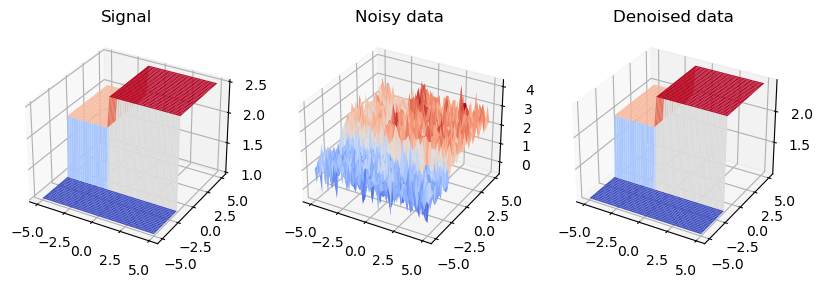

In [6]:
fig = plt.figure(figsize=(10, 5))  

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, X, cmap='coolwarm')
ax1.set_title('Signal')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
ax2.set_title('Noisy data')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1, X2, X_hat_constant, cmap='coolwarm')
ax3.set_title('Denoised data')

plt.show()

## Block-wise linear trend filtering
### Introduction
Now, we consider a more sophisticated task by generalizing the block-wise constant to a block-wise linear matrix.

The motivation of this generalization arises in some applications where adjacent locations share the same rate of change rather than the same value.

Consider a surface data $Y\in\mathbb{R}^{m\times n}$ over the grid $\{1, \cdots, m\}\times\{1, \cdots, n\}$. We want to approximate $Y$ with a block-wise linear surface $X$ as follows:
$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & x_{13} & \cdots & x_{1n}\\
x_{21} & x_{22} & x_{23} & \cdots & x_{2n}\\
x_{31} & x_{32} & x_{33} & \cdots & x_{3n}\\
\vdots & \vdots & \vdots &  \ddots & \vdots\\
x_{m1} & x_{m2} & x_{m3} & \cdots & x_{mn}\\
\end{bmatrix}.
$$
Note that the matrix $X$ itself is dense, and the sparsity is imposed on its second order difference of horizontal and vertical successive elements $x_{i, j-1}-2x_{i,j}+x_{i, j+1}$ and $x_{i-1, j}-2x_{i,j}+x_{i+1, j}$. To utilize the capacity of sparse optimization of ``scope``, we need to reparametrize $X$ with a sparse matrix $\Theta$. 

We introduce another manner to characterizing the piece-wise linear surface $X$. Consider the following four neighbourhood elements
\begin{align*}
&x_{i-1, j-1} &x_{i-1, j}\\
&x_{i, j-1} &x_{i, j}
\end{align*}
and they locate on the same plane if and only if $x_{i,j}=x_{i-1, j}+x_{i, j-1}-x_{i-1, j-1}$. On the contrary, if there is a jump at the position $(i, j)$, it holds that $x_{i,j}=x_{i-1, j}+x_{i, j-1}-x_{i-1, j-1}+\theta_{i,j}$ with $\theta_{i,j}\neq 0$. Thus, we can iteratively represent the dense matrix $X=(x_{i,j})$ with a sparse matrix $\Theta=(\theta_{i,j})$. The first row and the first column is represented as 
$$
x_{11}=\theta_{11}, x_{12}=\theta_{11}+\theta_{12}, \cdots, x_{1n}=\theta_{11}+(n-1)\theta_{12}+(n-2)\theta_{13}\cdots+\theta_{1n}
$$
$$
x_{11}=\theta_{11}, x_{21}=\theta_{11}+\theta_{21}, \cdots, x_{m1}=\theta_{11}+(m-1)\theta_{21}+(m-2)\theta_{31}\cdots+\theta_{m1}.
$$

For other elements, we have for $i\geq 2, j\geq 2$ that
$$
x_{ij}=\sum_{s=1}^i\sum_{t=1}^jc_{st}\theta_{st} \quad\text{ with }\quad
c_{st}= \begin{cases}
1 \quad & s=t=1 \\
1 \quad & s=i, t=j  \\
(i-s)+(j-t) \quad & \text{otherwise}
\end{cases} .
$$

### Implementation
Denote $p=m\times n$, we vectorize the matrices $X$, $\Theta\in\mathbb{R}^{m\times n}$ as $p$-dimensional vectors $\mathrm{Vec}(\Theta)$ and $\mathrm{Vec}(X)\in\mathbb{R}^p$ in a row-wise manner.
The following function ``get_c`` computes the coefficients $c_{st}, 1\leq s\leq i, 1\leq t\leq j$ and the function ``gen_matrix`` computes the coefficient matrix $C$ statisfying 
$$\mathrm{Vec}(X) = C \mathrm{Vec}(\Theta).$$

In [7]:
m, n = 40, 40
p = m * n

def get_c(i, j, s, t):
    if (s > i) or (t > j):
        return 0
    elif (s==0) and (t==0):
        return 1
    elif (s==i) and (t==j):
        return 1
    else:
        return i - s + j - t

# the (k, l) element C(k, l) of the matrix C is gen_matrix(k, l)
def gen_matrix(k, l):
    i = k // n
    j = k % n
    s = l // n
    t = l % n
    return get_c(i, j, s, t)

C = np.zeros((p, p))
for k in range(p):
    for l in range(p):
        C[k, l] = gen_matrix(k, l)

Then, the spatial trend filtering can be formulated as follows
$$\min_{\theta\in\mathbb{R}^p} \|Y-C\theta\|_2^2 \text{ s.t. } \|\theta\|_0\leq \mathrm{sparsity}$$
where $Y\in\mathbb{R}^{m\times n}$ is a given matrix data, $C=(c_{st})\in\mathbb{R}^{p\times p}$ is a known coefficient matrix constructed as above, $\theta\in\mathbb{R}^p$ is the optimized variable and ``sparsity`` is a user-defined sparsity parameter.

The following function ``stf_linear`` implements the above block-wise linear trend filtering algorithm.

In [8]:
def stf_linear(Y, sparsity):
    m, n = Y.shape
    p = m * n
    y = Y.reshape(-1)

    def custom_objective(params):
        return jnp.mean(jnp.square(y - C @ params))
    
    solver = ScopeSolver(p, sparsity)
    params = solver.solve(custom_objective)
    X_hat = (C @ params).reshape(m, n)
    return X_hat

### Synthetic data example
In the following, we generate a piece-wise linear surface $X$ with the above parameterization such that $\mathrm{Vec}(X) = C \mathrm{Vec}(\Theta)$ where $\mathrm{Vec}(\Theta)$ is a $5$-sparse vector with all nonzero elements being $0.2$. 

Then, the data $Y$ is obatined by adding Gaussian noise to $X$ satisfying $y_{ij}=x_{ij}+2\mathcal{N}(0, 1), 1\leq i\leq m, 1\leq j\leq n$.

The following figure shows that our parameterization actually has the ability to represent a piece-wise linear surface with a sparse vector.

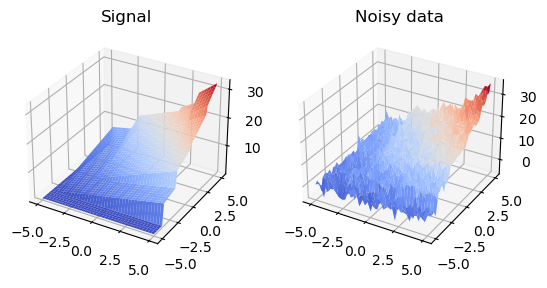

In [9]:
xx1 = np.linspace(-5, 5, m)
xx2 = np.linspace(-5, 5, n)
X1, X2 = np.meshgrid(xx2, xx2)

theta = np.zeros(p)
pos = [0, 242, 572, 953, 1347]
theta[pos] = 0.2 
X = (C @ theta).reshape(m, n)

rng = np.random.default_rng(666)
noise = rng.standard_normal((m, n)) * 2
Y = X + noise

fig = plt.figure(figsize=(10, 5))  

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, X, cmap='coolwarm')
ax1.set_title('Signal')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
ax2.set_title('Noisy data')

plt.show()

The following estimator ``X_hat_linear`` is obtained with our defined function ``stf_linear``.

In [10]:
X_hat_linear = stf_linear(Y, sparsity=5)

The quality of this estimator is visualized in the following figure.

We see that ``X_hat_linear`` filter the noisy data $Y$ and approximate the true piecewise linear surface $X$ well.

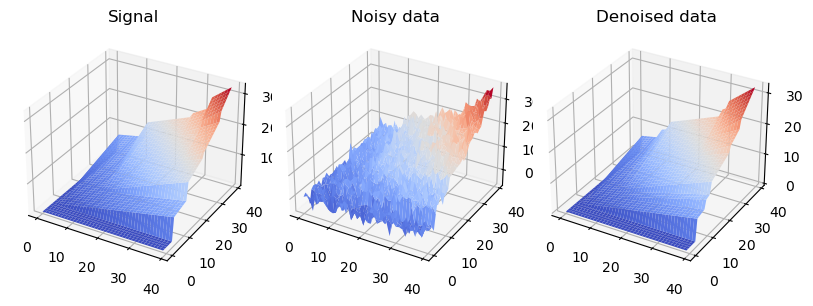

In [11]:
fig = plt.figure(figsize=(8, 8))  

xx1 = np.arange(m)
xx2 = np.arange(n)
X1, X2 = np.meshgrid(xx2, xx2)

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, X, cmap='coolwarm')
ax1.set_title('Signal')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, Y, cmap='coolwarm')
ax2.set_title('Noisy data')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1, X2, X_hat_linear, cmap='coolwarm')
ax3.set_title('Denoised data')

plt.tight_layout()
plt.show()

# Reference

- [1] Kim S J, Koh K, Boyd S, et al. $\ell_1$ trend filtering[J]. SIAM review, 2009, 51(2): 339-360.